# Training an LSTM model on books dataset

First we import necessary packages for our project

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm

## Preparing Dataset

Initialize the project root, data, and model directories.

In [2]:
# get data and model directories
project_root = Path('__file__').resolve().parents[1]
data_dir = project_root / 'data/'
model_dir = project_root / 'models/bn_lstm'
os.makedirs(model_dir, exist_ok=True) # Create if does not exist

Get list of files in the data directory

In [3]:
filenames = [str(file) for file in Path(data_dir).glob('**/*.txt')]

Split the files for training and testing. We are randomly shuffling the files and selecting only first 40 for training and next 10 for testing.

In [4]:
random.shuffle(filenames) # randomly shuffle the data
training_filenames = filenames[:40]
test_filenames = filenames[:10]

Now we create a function that creates a tokenizer with `max_words`, fit it on training files and save to `model_dir`.

In [5]:
def create_tokenizer(files, max_words, model_dir):
    tokenizer = Tokenizer(num_words=max_words)
    for file in tqdm(files):
        with open(file, 'r') as f:
            lines = f.read().split('\n')
            tokenizer.fit_on_texts(lines)
    save_path = model_dir / 'tokenizer.pickle'
    # save the tokenizer in model dir
    with open(save_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return tokenizer

Define max words and max sequence length

In [6]:
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100

Now create the tokenizer calling the function and passing the defined constants

In [7]:
tokenizer = create_tokenizer(training_filenames, MAX_WORDS, model_dir)

100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.21it/s]


`create_dataset` creates a dataset from given `files` and returns two variables - `predictors` which is a sequence of previous words of length `max_sequence_length - 1` and `labels` which is an integer between 0 to `max_words + 1`.
Note that, converting to categorical variables leads to `MemoryError` since it tries to create a sequence of `number of elements in training or test set * (MAX_WORDS + 1)` shape. We are following [this blog](https://medium.com/deep-learning-with-keras/which-activation-loss-functions-in-multi-class-clasification-4cd599e4e61f) and keeping the label as an integer.

In [35]:
def create_dataset(tokenizer, files, max_words, max_sequence_length):
    input_sequences = []

    for file in tqdm(files):
        with open(file, 'r') as f:
            lines = f.read().split('\n')
            token_list = tokenizer.texts_to_sequences(lines)
            for tokens in token_list:
                for i in range(1, len(tokens)):
                    # keep only sequences of length <= max_sequence_length
                    n_gram_sequence = tokens[max(0, i+1-max_sequence_length):i+1]
                    input_sequences.append(n_gram_sequence)

    # pad sequences with 0s so that all sequences have same length
    input_sequences = tf.keras.preprocessing.sequence.pad_sequences(
        input_sequences, maxlen=max_sequence_length, padding='pre')

    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    del input_sequences
    return predictors, label

Now we create training dataset `X_train` and `y_train` from training files and test dataset `X_test` and `y_test` from test files.

In [36]:
X_train, y_train = create_dataset(tokenizer, training_filenames, MAX_WORDS, MAX_SEQUENCE_LENGTH)
X_test, y_test = create_dataset(tokenizer, test_filenames, MAX_WORDS, MAX_SEQUENCE_LENGTH)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.85it/s]


## Creating and Training Model

Create a sequential LSTM model and compile the model with loss `sparse_categorical_crossentropy`, optimizer `adam` and metric `sparse_categorical_accuracy`. We are using sparse categorical crossentropy since the values are integers, not one-hot encoded, see this question on [stackexchange](https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other) for details.

In [49]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        MAX_WORDS+1, MAX_SEQUENCE_LENGTH-1, input_length=MAX_SEQUENCE_LENGTH-1),
    tf.keras.layers.LSTM(64, return_sequences=True, name='lstm_1'),
    tf.keras.layers.LSTM(32, name='lstm_2'),
    tf.keras.layers.Dense(MAX_WORDS+1, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['sparse_categorical_accuracy'])

Create callbacks `EarlyStopping` which monitors `val_loss` for 10 epochs, and `ModelCheckpoint` which saves best model to `model_dir`.

In [50]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, mode='auto')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    str(model_dir), monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Start training the model and store the training results in `history`.

In [52]:
history = model.fit(X_train, y_train, batch_size=256,
                    epochs=10, validation_split=0.2,
                    callbacks=[earlystop, checkpoint])

Epoch 1/10
2974/2975 [============================>.] - ETA: 0s - loss: 7.6793 - sparse_categorical_accuracy: 0.0163
Epoch 1: val_loss improved from inf to 7.55498, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


2975/2975 [==============================] - 67s 22ms/step - loss: 7.6793 - sparse_categorical_accuracy: 0.0163 - val_loss: 7.5550 - val_sparse_categorical_accuracy: 0.0265
Epoch 2/10
2974/2975 [============================>.] - ETA: 0s - loss: 7.2964 - sparse_categorical_accuracy: 0.0322
Epoch 2: val_loss improved from 7.55498 to 7.37281, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


2975/2975 [==============================] - 65s 22ms/step - loss: 7.2964 - sparse_categorical_accuracy: 0.0322 - val_loss: 7.3728 - val_sparse_categorical_accuracy: 0.0375
Epoch 3/10
2974/2975 [============================>.] - ETA: 0s - loss: 7.0297 - sparse_categorical_accuracy: 0.0419
Epoch 3: val_loss improved from 7.37281 to 7.32600, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


2975/2975 [==============================] - 66s 22ms/step - loss: 7.0297 - sparse_categorical_accuracy: 0.0419 - val_loss: 7.3260 - val_sparse_categorical_accuracy: 0.0390
Epoch 4/10
2974/2975 [============================>.] - ETA: 0s - loss: 6.8423 - sparse_categorical_accuracy: 0.0488
Epoch 4: val_loss improved from 7.32600 to 7.30998, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


2975/2975 [==============================] - 64s 22ms/step - loss: 6.8423 - sparse_categorical_accuracy: 0.0488 - val_loss: 7.3100 - val_sparse_categorical_accuracy: 0.0402
Epoch 5/10
2974/2975 [============================>.] - ETA: 0s - loss: 6.7050 - sparse_categorical_accuracy: 0.0545
Epoch 5: val_loss improved from 7.30998 to 7.30042, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


2975/2975 [==============================] - 65s 22ms/step - loss: 6.7050 - sparse_categorical_accuracy: 0.0545 - val_loss: 7.3004 - val_sparse_categorical_accuracy: 0.0466
Epoch 6/10
2974/2975 [============================>.] - ETA: 0s - loss: 6.5812 - sparse_categorical_accuracy: 0.0603
Epoch 6: val_loss improved from 7.30042 to 7.28492, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


2975/2975 [==============================] - 65s 22ms/step - loss: 6.5812 - sparse_categorical_accuracy: 0.0603 - val_loss: 7.2849 - val_sparse_categorical_accuracy: 0.0472
Epoch 7/10
2974/2975 [============================>.] - ETA: 0s - loss: 6.4750 - sparse_categorical_accuracy: 0.0659
Epoch 7: val_loss did not improve from 7.28492
2975/2975 [==============================] - 62s 21ms/step - loss: 6.4750 - sparse_categorical_accuracy: 0.0659 - val_loss: 7.2953 - val_sparse_categorical_accuracy: 0.0487
Epoch 8/10
2974/2975 [============================>.] - ETA: 0s - loss: 6.3916 - sparse_categorical_accuracy: 0.0708
Epoch 8: val_loss improved from 7.28492 to 7.28369, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


2975/2975 [==============================] - 69s 23ms/step - loss: 6.3916 - sparse_categorical_accuracy: 0.0708 - val_loss: 7.2837 - val_sparse_categorical_accuracy: 0.0507
Epoch 9/10
2974/2975 [============================>.] - ETA: 0s - loss: 6.3213 - sparse_categorical_accuracy: 0.0750
Epoch 9: val_loss did not improve from 7.28369
2975/2975 [==============================] - 62s 21ms/step - loss: 6.3213 - sparse_categorical_accuracy: 0.0750 - val_loss: 7.3153 - val_sparse_categorical_accuracy: 0.0506
Epoch 10/10
2974/2975 [============================>.] - ETA: 0s - loss: 6.2600 - sparse_categorical_accuracy: 0.0785
Epoch 10: val_loss did not improve from 7.28369
2975/2975 [==============================] - 62s 21ms/step - loss: 6.2600 - sparse_categorical_accuracy: 0.0785 - val_loss: 7.3238 - val_sparse_categorical_accuracy: 0.0529


Next, we plot the training accuracy and loss from `history.history`.

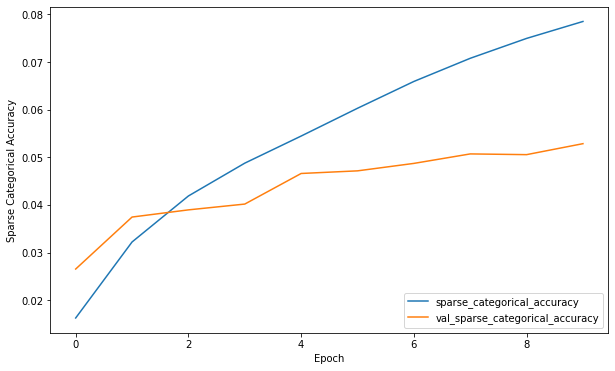

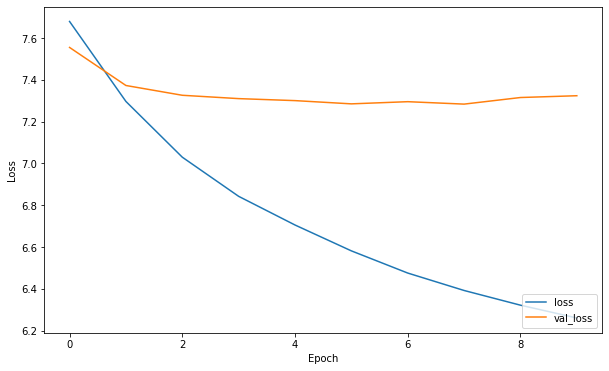

In [53]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Accuracy')
plt.legend(loc='lower right')
plt.show()
fig.savefig(str(model_dir / f'sparse_categorical_accuracy.png'), dpi=fig.dpi)

fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()
fig.savefig(str(model_dir / f'sparse_categorical_loss.png'), dpi=fig.dpi)

Finally we evaluate the model on test data.

In [55]:
model.evaluate(X_test, y_test, batch_size=128)

2259/2259 [==============================] - 17s 7ms/step - loss: 6.0375 - sparse_categorical_accuracy: 0.0909


[6.037466049194336, 0.09086915105581284]